In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [74]:
#!python -m wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv -o New_York_City_Airbnb_Open_Data.csv

In [75]:
data = pd.read_csv('New_York_City_Airbnb_Open_Data.csv')

In [76]:
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


<AxesSubplot:xlabel='price', ylabel='Count'>

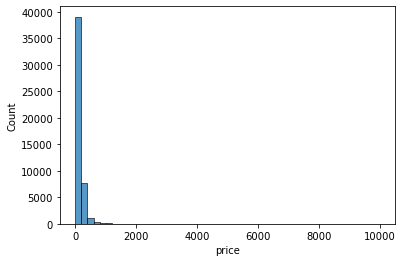

In [77]:
sns.histplot(data.price,bins=50)
#price variable histplot has a long tail

In [78]:
data.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [79]:
data.reviews_per_month.fillna(0,inplace=True) 
#data.reviews_per_month.fillna(data.reviews_per_month.mean(),inplace=True)

In [80]:
X =  data[[
    'latitude',
    'longitude',
    'minimum_nights',
    'number_of_reviews',
    'reviews_per_month',
    'calculated_host_listings_count',
    'availability_365'
]]


y = data.price.values

In [81]:
X.isnull().sum()

latitude                          0
longitude                         0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [82]:
np.percentile(X.minimum_nights,50)
#Median for minimum_nights

3.0

In [83]:
len(X)

48895

In [84]:
n_val = int(0.2 * len(X))
n_test = int(0.2 * len(X))
n_train = len(X) - n_val - n_test

In [85]:
d_index = np.arange(len(X))
np.random.seed(42)
np.random.shuffle(d_index)


In [86]:
X_train = X.iloc[d_index[:n_train]].reset_index(drop=True)
X_valid = X.iloc[d_index[n_train :n_train + n_val]].reset_index(drop=True)
X_test  = X.iloc[d_index[n_train + n_val:]].reset_index(drop=True)

In [87]:
y = np.log1p(y) #to reduce the impact of long tail of y histplot
y_train = y[d_index[:n_train]]
y_valid = y[d_index[n_train :n_train + n_val]]
y_test  = y[d_index[n_train + n_val:]]

In [88]:
def linear_reg(X,y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones,X])
    XTX = X.T.dot(X)
    XVX = np.linalg.inv(XTX) 
    w = XVX.dot(X.T).dot(y)
    return w[0], w[1:]

In [89]:
linear_reg(X_train,y_train)

(-419.9126602932141,
 array([ 1.30676226e+00, -5.02167857e+00, -5.59803112e-04, -4.07634897e-04,
        -8.25470057e-03,  1.33371319e-03,  6.50203891e-04]))

In [90]:
def RMSE(W_base, W, X, y):
    y_pred = W_base + X@W
    return np.sqrt(((y-y_pred)**2).mean())

In [91]:
W0,W = linear_reg(X_train,y_train)
RMSE(W0, W, X_valid, y_valid)

0.6430337788397475

In [92]:
#0.6430337788397475 #for fillna with zeros

In [93]:
def regularized_linear_reg(X, y, r = 0.01):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones,X])
    
    XTX = X.T.dot(X) 
    XTX = XTX + (r * np.eye(XTX.shape[0]))
    XVX = np.linalg.inv(XTX) 
    w = XVX.dot(X.T).dot(y)
    return w[0], w[1:]

In [94]:
W0,W = regularized_linear_reg(X_train,y_train)
RMSE(W0, W, X_valid, y_valid)

0.6557528427055406

In [95]:

r = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]

for i in r:
    W0,W = regularized_linear_reg(X_train,y_train, i)
    res = RMSE(W0, W, X_valid, y_valid)
    print(f'Regularization parameter: {i}, RMSE: {res} ')

Regularization parameter: 0, RMSE: 0.6430337788397475 
Regularization parameter: 1e-06, RMSE: 0.6430341157299516 
Regularization parameter: 0.0001, RMSE: 0.6430723153437234 
Regularization parameter: 0.001, RMSE: 0.6437669735059144 
Regularization parameter: 0.01, RMSE: 0.6557528427055406 
Regularization parameter: 0.1, RMSE: 0.6773299642422751 
Regularization parameter: 1, RMSE: 0.6823116950157638 
Regularization parameter: 5, RMSE: 0.6827915727842327 
Regularization parameter: 10, RMSE: 0.6828430212100244 


In [97]:
W0,W = regularized_linear_reg(X_train,y_train, 0)
RMSE(W0, W, X_test, y_test)

0.6536337650040558

In [98]:
def prep(data, seed = 42):
    X =  data[[
    'latitude',
    'longitude',
    'minimum_nights',
    'number_of_reviews',
    'reviews_per_month',
    'calculated_host_listings_count',
    'availability_365'
    ]]


    y = data.price.values
    
    d_index = np.arange(len(X))
    np.random.seed(seed)
    np.random.shuffle(d_index)
    
    X_train = X.iloc[d_index[:n_train]].reset_index(drop=True)
    X_valid = X.iloc[d_index[n_train :n_train + n_val]].reset_index(drop=True)
    X_test  = X.iloc[d_index[n_train + n_val:]].reset_index(drop=True)
    
    y = np.log1p(y) #to reduce the impact of long tail of y histplot
    y_train = y[d_index[:n_train]]
    y_valid = y[d_index[n_train :n_train + n_val]]
    y_test  = y[d_index[n_train + n_val:]]
     
    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [103]:
seed = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
result = []
for i in seed:
    X_train, X_valid, X_test, y_train, y_valid, y_test = prep(data, i)
    W0,W = regularized_linear_reg(X_valid,y_valid, 0)
    res = RMSE(W0, W, X_test, y_test)
    result.append(res)

In [104]:
std = np.std(result)
round(std, 3)

0.007

In [105]:

X_train, X_valid, X_test, y_train, y_valid, y_test = prep(data, 9)
W0,W = regularized_linear_reg(X_test,y_test, 0.001)
RMSE(W0, W, X_test, y_test)

0.6472694737808051